In [3]:
import librosa
import librosa.display
import scipy
import os
import matplotlib.pyplot as plt
import numpy as np

# Load the audio file
file_path = os.path.join('..', 'FFT', 'data', 'acdl.wav')
y, sr = librosa.load(file_path)

y = librosa.util.normalize(y)


The constant Q transform (CQT) is a type of time-frequency analysis commonly used in audio signal processing. It decomposes a signal into its frequency components, with each octave divided into a constant number of bins, resulting in a logarithmically spaced frequency axis. 

This method is particularly useful for analyzing musical signals since it provides a more perceptually relevant representation of pitch. In the provided code snippet using the librosa.cqt() function, it computes the CQT of the audio signal y with a sampling rate of sr. 

The fmin parameter sets the minimum frequency, often specified in Hertz (Hz), while bins_per_octave determines the resolution of the frequency axis. 

The result c will have a shape where the rows represent different frequency bins and the columns represent different time frames, providing a time-frequency representation of the input audio signal.


You can learn more about CQT in this video :
https://www.youtube.com/watch?v=Cl-m4X3rwac





In [4]:
c = librosa.cqt(y, sr=sr, fmin=librosa.note_to_hz('C1'), bins_per_octave=12 )

/tmp/ipykernel_36116/3045842074.py:3: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(c, ref=np.max), sr=sr, x_axis='time', y_axis='cqt_note')


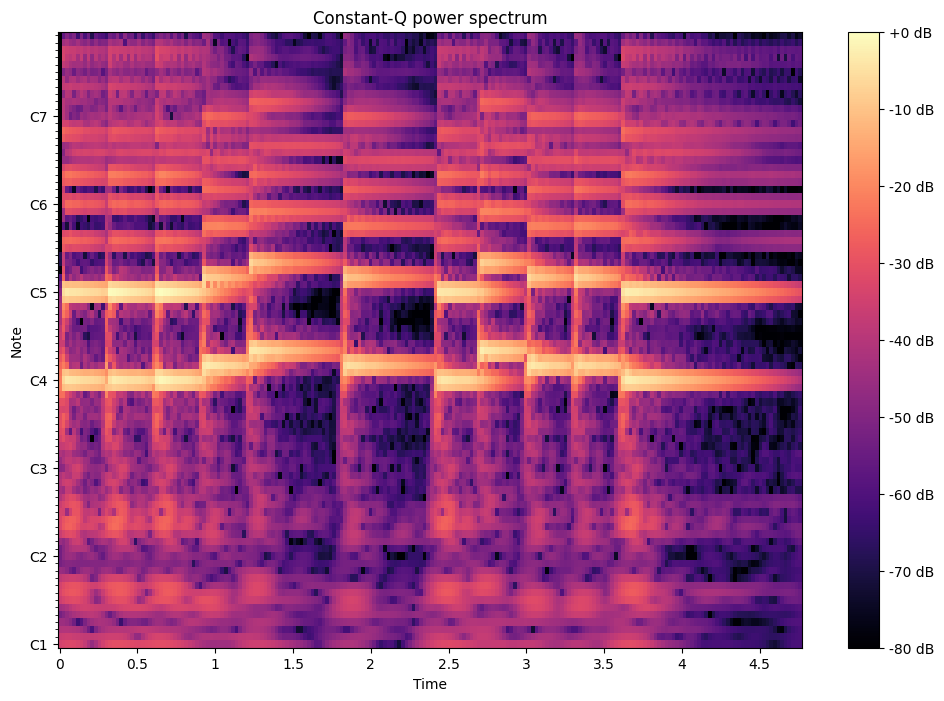

In [13]:
# Display the CQT
plt.figure(figsize=(12, 8))
librosa.display.specshow(librosa.amplitude_to_db(c, ref=np.max), sr=sr, x_axis='time', y_axis='cqt_note')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q power spectrum')
plt.show()


In [6]:
def detect_note_offsets(y, sr, onsets):
    hop_length = 512
    # Calculate onset strength envelope
    onset_envelope = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)

    offsets = []
    for onset in onsets:
        # Find the frame corresponding to the onset time
        onset_frame = librosa.time_to_frames(onset, sr=sr, hop_length=hop_length)

        # Search for the next local minimum in the onset strength envelope after the onset
        offset_frame = onset_frame + np.argmin(onset_envelope[onset_frame:])

        # Convert frame to time
        offset_time = librosa.frames_to_time(offset_frame, sr=sr, hop_length=hop_length)

        offsets.append(offset_time)

    return offsets

Onset detection in the context of music analysis is the process of identifying points in time within an audio signal where significant events or notes begin. 

In [7]:
hop_length = 512

# Get the frame->beat strength profile
onset_envelope = librosa.onset.onset_strength(y=y,
                                              sr=sr,
                                              hop_length=hop_length,
                                              aggregate=np.median)

# Locate note onset events
onsets = librosa.onset.onset_detect(y=y,
                                    sr=sr,
                                    onset_envelope=onset_envelope,
                                    hop_length=hop_length,
                                    backtrack=True)

# Convert frames to time
times = librosa.frames_to_time(np.arange(len(onset_envelope)),
                               sr=sr,
                               hop_length=hop_length)

print('Peaks', onsets)
print('Times', times[onsets])

offsets = detect_note_offsets(y, sr, times[onsets])
print('Offsets', offsets)


Peaks [  2  13  27  40  53  78 104 116 130 143 156]
Times [0.04643991 0.30185941 0.62693878 0.92879819 1.2306576  1.81115646
 2.41487528 2.69351474 3.0185941  3.32045351 3.62231293]
Offsets [0.046439909297052155, 1.9504761904761905, 1.9504761904761905, 1.9504761904761905, 1.9504761904761905, 1.9504761904761905, 3.1811337868480725, 3.1811337868480725, 3.1811337868480725, 3.436553287981859, 4.08671201814059]


These graphs show the behaviour of the onset detection algorithm

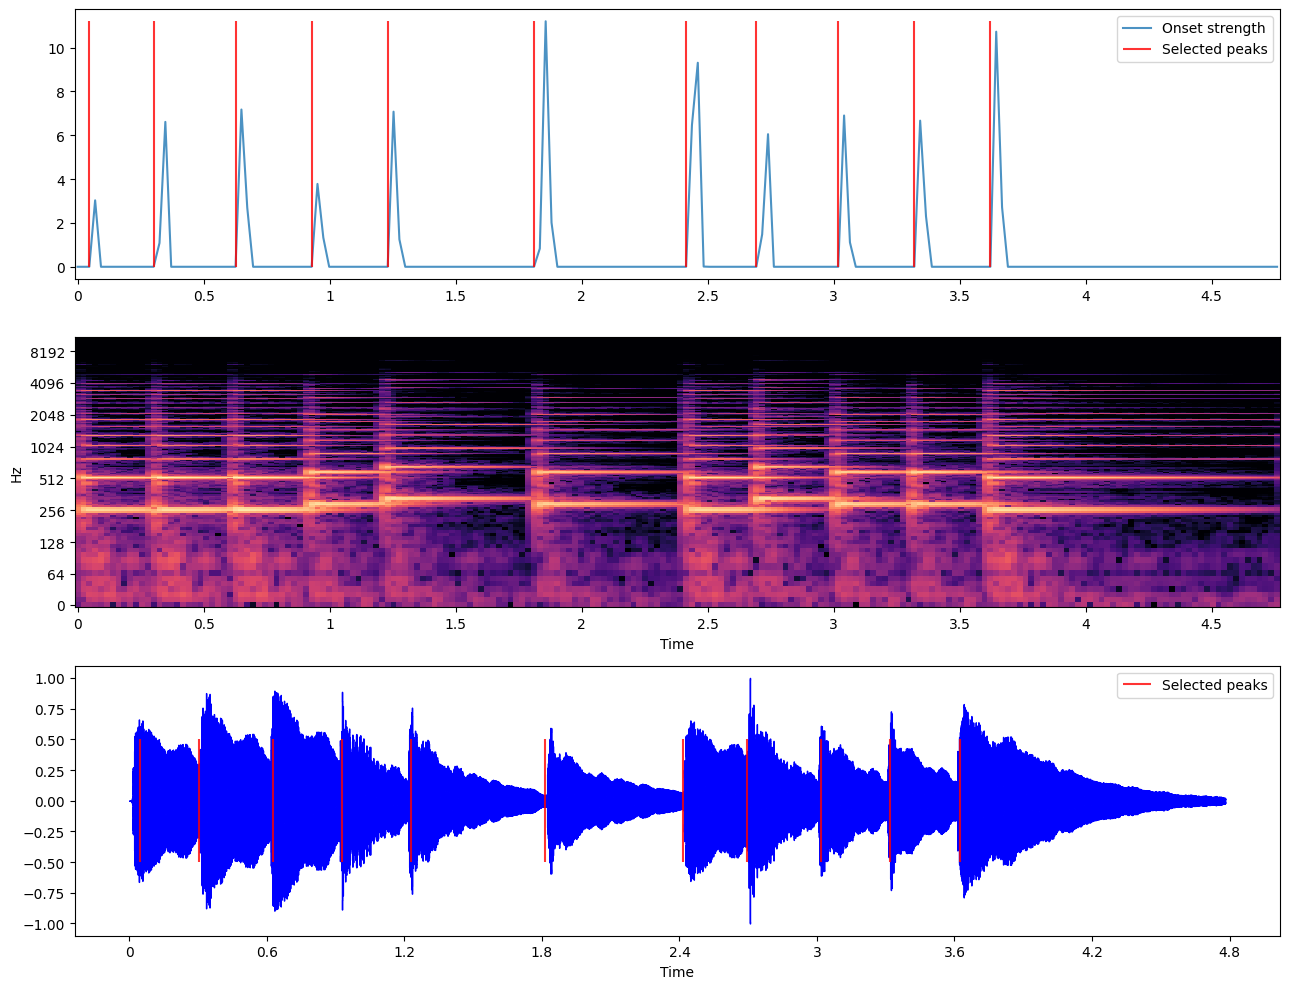

In [8]:
plt.figure(figsize=(13, 10))

# Draw spectrogram
ax = plt.subplot(3, 1, 2)
D = librosa.stft(y)
librosa.display.specshow(
    librosa.amplitude_to_db(librosa.magphase(D)[0], ref=np.max),
    sr=sr,
    hop_length=hop_length,
    y_axis='log',
    x_axis='time')

# Draw onsets & strenghts
plt.subplot(3, 1, 1, sharex=ax)
plt.plot(times, onset_envelope, alpha=0.8, label='Onset strength')
plt.vlines(times[onsets], 0, onset_envelope.max(),
           color='r', alpha=0.8, label='Selected peaks')
plt.legend(frameon=True, framealpha=0.8)

# Draw waveform with onset markings
plt.subplot(3, 1, 3)
plt.vlines(times[onsets], -0.5, 0.5, color='r',
           alpha=0.8, label='Selected peaks')
plt.legend(frameon=True, framealpha=0.8)
librosa.display.waveshow(y, sr=sr, color="blue")

plt.axis('tight')
plt.tight_layout()


Now that we have the cqt and 

In [9]:
# Compute the Constant-Q Transform
C = np.abs(librosa.cqt(y, sr=sr))
import scipy.signal
# Merge peaks after the onset events
detected_notes = []

for onset_time in librosa.frames_to_time(onsets, sr=sr, hop_length=hop_length):
    # Find the frame corresponding to the onset time
    onset_frame = librosa.time_to_frames(onset_time, sr=sr, hop_length=hop_length)

    # Define a time window after the onset frame
    window_size = 0.2  # Adjust this window size as needed
    window_frames = librosa.time_to_frames([onset_time, onset_time + window_size], sr=sr, hop_length=hop_length)

    # Check if the window frames are within the bounds
    if window_frames[1] < C.shape[1]:
        # Find peaks within the window after the onset time
        peaks, _ = scipy.signal.find_peaks(C[:, window_frames[1]], height=1.5, distance=5)

        # Convert frequency peaks to note names
        if len(peaks) > 0:
            freqs = librosa.cqt_frequencies(C.shape[0], fmin=librosa.note_to_hz('C1'))[peaks]
            notes = [librosa.hz_to_note(freq) for freq in freqs]
            detected_notes.append(notes)

print(detected_notes)



[['C4', 'C5'], ['C4', 'C5'], ['C4', 'C5'], ['D4'], ['E4'], ['D4'], ['C4', 'C5'], ['E4'], ['D4'], ['D4'], ['C4', 'C5']]


You can adjust the height parameter and the distance parameter to check its influence on the detected peaks.

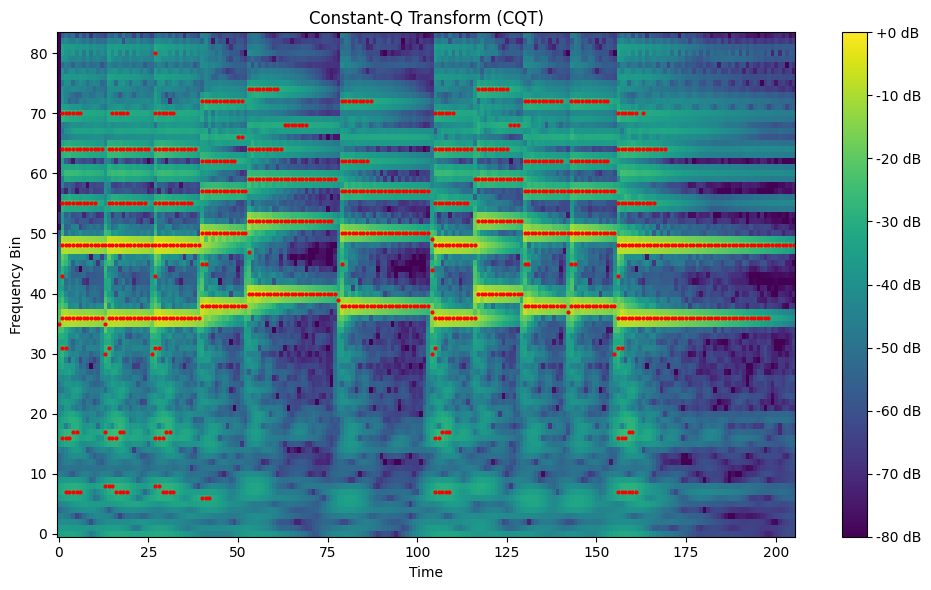

In [15]:
import matplotlib.pyplot as plt

# Plot the spectrogram
plt.figure(figsize=(10, 6))
plt.imshow(librosa.amplitude_to_db(C, ref=np.max), aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Constant-Q Transform (CQT)')
plt.xlabel('Time')
plt.ylabel('Frequency Bin')
plt.tight_layout()

# Plot peaks
for i in range(C.shape[1]):
    peaks, _ = scipy.signal.find_peaks(C[:, i], height=0.2, distance=5)
    plt.plot([i] * len(peaks), peaks, 'ro', markersize=2)

plt.show()


In [11]:
import musicpy as mp
print(detected_notes)
for i in range(len(detected_notes)):
    for j in range(len(detected_notes[i])):
        detected_notes[i][j] = detected_notes[i][j].replace('♯', '#').replace('♭', 'b').replace('-', '')
final_chord = mp.chord(detected_notes[0])
for i in range(1, len(detected_notes)):
    final_chord = final_chord | mp.chord(detected_notes[i])
# mp.play(final_chord, 120)

[['C4', 'C5'], ['C4', 'C5'], ['C4', 'C5'], ['D4'], ['E4'], ['D4'], ['C4', 'C5'], ['E4'], ['D4'], ['D4'], ['C4', 'C5']]


In [12]:
def seconds_to_beats(timestamps, bpm):
    # Calculate the duration of each beat in seconds
    beat_duration = 60 / bpm

    # Convert each timestamp from seconds to beats
    beats = [timestamp / beat_duration for timestamp in timestamps]

    return beats

times_in_beats = seconds_to_beats(times[onsets], 120)

In [13]:
notes = list(zip(detected_notes, times_in_beats))
print(times[onsets])
print(notes)

[0.04643991 0.30185941 0.62693878 0.92879819 1.2306576  1.81115646
 2.41487528 2.69351474 3.0185941  3.32045351 3.62231293]
[(['C4', 'C5'], 0.09287981859410431), (['C4', 'C5'], 0.603718820861678), (['C4', 'C5'], 1.253877551020408), (['D4'], 1.8575963718820863), (['E4'], 2.461315192743764), (['D4'], 3.622312925170068), (['C4', 'C5'], 4.829750566893424), (['E4'], 5.38702947845805), (['D4'], 6.03718820861678), (['D4'], 6.640907029478458), (['C4', 'C5'], 7.244625850340136)]


In [14]:
from midiutil import MIDIFile
import math
def notes_to_midi(notes, output_file):
    # Create a MIDIFile object with 1 track
    midi = MIDIFile(1)

    # Add track name and tempo
    track = 0
    time = 0
    midi.addTrackName(track, time, "Detected Notes")
    midi.addTempo(track, time, 120)  # Tempo in BPM

    # Add notes to the MIDI file
    for chord in notes:
        for note in chord[0]:
            pitch = librosa.note_to_midi(note)  # Convert note name to MIDI pitch
            duration = 0.5  # Duration of each note (in beats), adjust as needed
            start_time = chord[1]  # Start time of the note
            end_time = start_time + duration  # End time of the note

            # Add note to the MIDI track
            midi.addNote(track, channel=0, pitch=pitch, time=start_time, duration=duration, volume=100)

    # Write the MIDI data to a file
    with open(output_file, "wb") as midi_file:
        midi.writeFile(midi_file)

# Example usage:
output_file = "detected_notes.mid"  # Output MIDI file path
notes_to_midi(notes, output_file)

